In [ ]:
#libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
#tensorflow packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:
#load cifar10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
#image and labels preprocessing
# normalize pixels
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten the labels
y_train, y_test = y_train.flatten(), y_test.flatten()

In [ ]:
#change datatype from float64 to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# EDA

In [ ]:
#x_train ifo
print("Shape:", x_train.shape)
print("Data Type:", x_train.dtype)
print("Number of Elements:", np.prod(x_train.shape))


Shape: (50000, 32, 32, 3)
Data Type: float32
Number of Elements: 153600000


In [ ]:
print(np.info(x_train))

class:  ndarray
shape:  (50000, 32, 32, 3)
strides:  (12288, 128, 4, 4096)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x7b3628835010
byteorder:  little
byteswap:  False
type: float32
None


In [ ]:
#explore classes
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
print("Number of classes: ", num_classes)

Number of classes:  10


In [ ]:
#class names from CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f"Class names: {class_names}")

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
#dict to store the counts
image_counts_per_class = {}
#count the occurrences of each class
for i in range(10):
  image_counts_per_class[i]= np.sum(y_train == i)

for class_index, count in image_counts_per_class.items():
  print(f"Class {class_index}: {count} images")


Class 0: 5000 images
Class 1: 5000 images
Class 2: 5000 images
Class 3: 5000 images
Class 4: 5000 images
Class 5: 5000 images
Class 6: 5000 images
Class 7: 5000 images
Class 8: 5000 images
Class 9: 5000 images


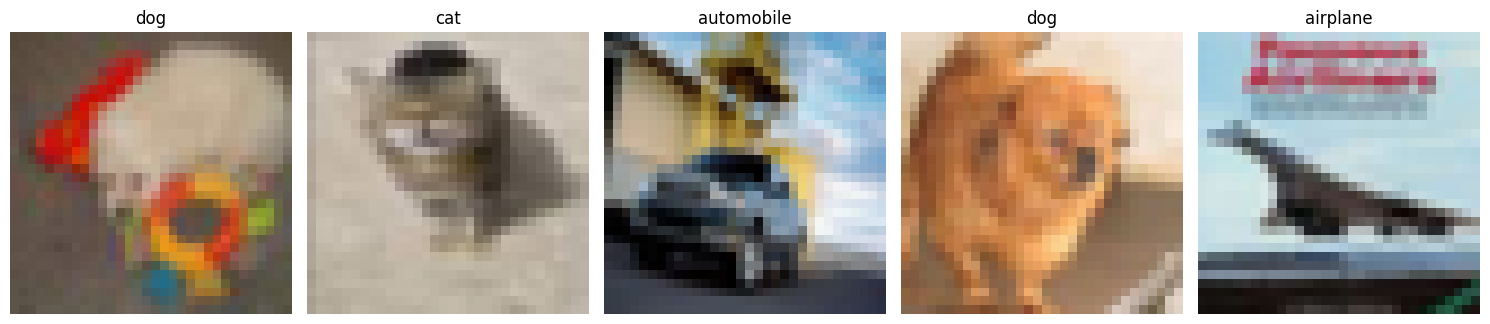

In [ ]:
#images preview from x_train
num_images_to_show = 5
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15,5))
for i in range(num_images_to_show):
  random_index = np.random.randint(0, len(x_train))
  image = x_train[random_index]
  label = y_train[random_index]
  class_name = class_names[label]

  axes[i].imshow(image)
  axes[i].set_title(class_name)
  axes[i].axis('off')

plt.tight_layout()
plt.show()

#EDA Results


*   Data is a 4d Numpy array
*   50,000 train images

*   10,000 test images
*   All images are 32x32 pixels

*   3 color channels for each pixel(RGB)
*   Dataset has 10 classes

*   Each class has 5000 images

*   Hence no class imbalance detected in the train set
*   Normalized the pixels by dividing by 255


*   Flattened labels changing y train from a 2D array with single-element row to a 1D array where each element is a label.











# Data Preprocessing

In [ ]:
#one-hot encoding: converting labels to categorical(vectorizing)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
#Split train data to get validation set (60:40)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)
print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (30000, 32, 32, 3)
Validation data shape: (20000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [ ]:
#checking pixel normalization
image = x_train[275]

# Checks the minimum and maximum values of the image data(should be between 0 and 1)
min_value = np.min(image)
max_value = np.max(image)

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: 0.01568627543747425
Maximum value: 0.95686274766922


In [ ]:
#create generators
batch_size = 32

train_generator= ImageDataGenerator().flow(
    x_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator= ImageDataGenerator().flow(
    x_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

test_generator= ImageDataGenerator().flow(
    x_test, y_test,
    batch_size=batch_size,
    shuffle=False
)


#Data Preprocessing Results


*   One hot encoding to convert the labels to categorical class mode i.e the labels will have a vector to represent each label
*   Split the training data to get a validation set


*   Test to confirm the pixels were normalized i.e rescaled
*   specified a batch size to det number of images processed together during each training iteration


*   Created train, val annd test geneators to be used in the training loop








#Baseline Model

In [ ]:
#model architecture
def create_and_train_model(model_number, train_generator, val_generator):
    # Creating the model layers
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   restore_best_weights=True)

    np.random.seed(123)
    model = tf.keras.models.Sequential()
    # Convolutional Block 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                            input_shape=(x_train[0].shape),
                            kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy',Precision(name='precision'),
                           Recall(name='recall')])

    # Training the model and storing the history
    history = model.fit(train_generator,
                        epochs=100,
                        validation_data=val_generator,
                        callbacks=[early_stopping])

    return model, history

In [ ]:
model1, history1 = create_and_train_model(1, train_generator, val_generator)
model1.save("model1.h5")

Epoch 1/100
938/938 [==============================] - 26s 19ms/step - loss: 2.1775 - accuracy: 0.3595 - precision: 0.4776 - recall: 0.1854 - val_loss: 1.6894 - val_accuracy: 0.5029 - val_precision: 0.7346 - val_recall: 0.2375
Epoch 2/100
938/938 [==============================] - 12s 12ms/step - loss: 1.7019 - accuracy: 0.4818 - precision: 0.6639 - recall: 0.2739 - val_loss: 1.6844 - val_accuracy: 0.4915 - val_precision: 0.6851 - val_recall: 0.3143
Epoch 3/100
938/938 [==============================] - 12s 12ms/step - loss: 1.5304 - accuracy: 0.5341 - precision: 0.6991 - recall: 0.3528 - val_loss: 1.4268 - val_accuracy: 0.5648 - val_precision: 0.7424 - val_recall: 0.3877
Epoch 4/100
938/938 [==============================] - 12s 12ms/step - loss: 1.4237 - accuracy: 0.5734 - precision: 0.7222 - recall: 0.4091 - val_loss: 1.3567 - val_accuracy: 0.5965 - val_precision: 0.7488 - val_recall: 0.4423
Epoch 5/100
938/938 [==============================] - 12s 12ms/step - loss: 1.3610 - accura

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


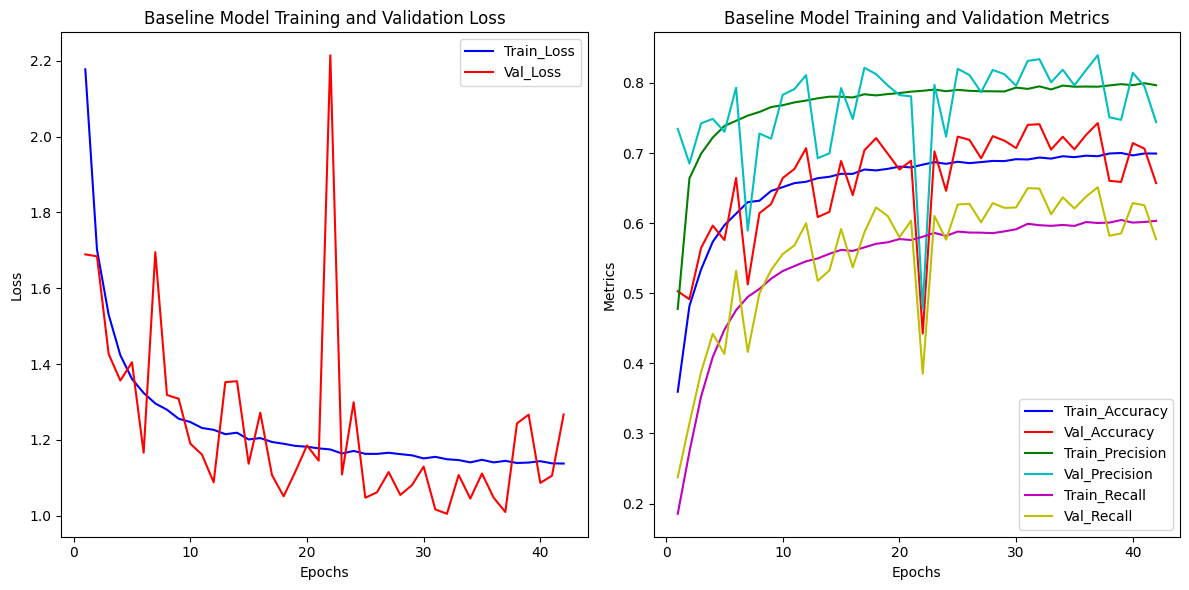

In [ ]:
# Accessing training history from the 'history' object
training_loss = history1.history['loss']
validation_loss = history1.history['val_loss']
training_accuracy = history1.history['accuracy']
validation_accuracy = history1.history['val_accuracy']
training_precision = history1.history['precision']
validation_precision = history1.history['val_precision']
training_recall = history1.history['recall']
validation_recall = history1.history['val_recall']

# Number of epochs
epochs = range(1, len(training_loss) + 1)

# creating a plot
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(epochs, training_loss, 'b-', label='Train_Loss')
plt.plot(epochs, validation_loss, 'r-', label='Val_Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Metrics
plt.subplot(122)
plt.plot(epochs, training_accuracy, 'b-', label='Train_Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Val_Accuracy')
plt.plot(epochs, training_precision, 'g-', label='Train_Precision')
plt.plot(epochs, validation_precision, 'c-', label='Val_Precision')
plt.plot(epochs, training_recall, 'm-', label='Train_Recall')
plt.plot(epochs, validation_recall, 'y-', label='Val_Recall')
plt.title('Baseline Model Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()


plt.tight_layout()
plt.show()

## Baseline Model output:
Minor overfitting detected. Due to usage of techniques like l2 regularization and dropout.

Both training and val loss however a bit high, meaning the model wont generalize as well unless optimized.

# With Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator
train_generator2 = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

In [ ]:
#model architecture
def create_and_train_model2(model_number, train_generator, val_generator):
    # Creating the model layers
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=20,
                                   restore_best_weights=True)

    np.random.seed(123)
    tf.random.set_seed(123)
    model = tf.keras.models.Sequential()
    # Convolutional Block 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                            input_shape=(x_train[0].shape),
                            kernel_regularizer=l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy',Precision(name='precision'),
                           Recall(name='recall')])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Training the model and storing the history
    history = model.fit(train_generator2,
                        epochs=150,
                        validation_data=val_generator,
                        callbacks=[early_stopping, reduce_lr])

    return model, history

In [ ]:
model2, history2 = create_and_train_model2(2, train_generator2, val_generator)
model2.save("model2.h5")

Epoch 1/150
938/938 [==============================] - 31s 30ms/step - loss: 2.2373 - accuracy: 0.2921 - precision: 0.3864 - recall: 0.1094 - val_loss: 1.7329 - val_accuracy: 0.4249 - val_precision: 0.6513 - val_recall: 0.1472 - lr: 0.0010
Epoch 2/150
938/938 [==============================] - 28s 29ms/step - loss: 1.8489 - accuracy: 0.3821 - precision: 0.5871 - recall: 0.1425 - val_loss: 1.6464 - val_accuracy: 0.4605 - val_precision: 0.6605 - val_recall: 0.2353 - lr: 0.0010
Epoch 3/150
938/938 [==============================] - 28s 30ms/step - loss: 1.7431 - accuracy: 0.4203 - precision: 0.6185 - recall: 0.1770 - val_loss: 1.8532 - val_accuracy: 0.4272 - val_precision: 0.5512 - val_recall: 0.3097 - lr: 0.0010
Epoch 4/150
938/938 [==============================] - 27s 29ms/step - loss: 1.6909 - accuracy: 0.4434 - precision: 0.6350 - recall: 0.2081 - val_loss: 1.4912 - val_accuracy: 0.5110 - val_precision: 0.6575 - val_recall: 0.3375 - lr: 0.0010
Epoch 5/150
938/938 [===================

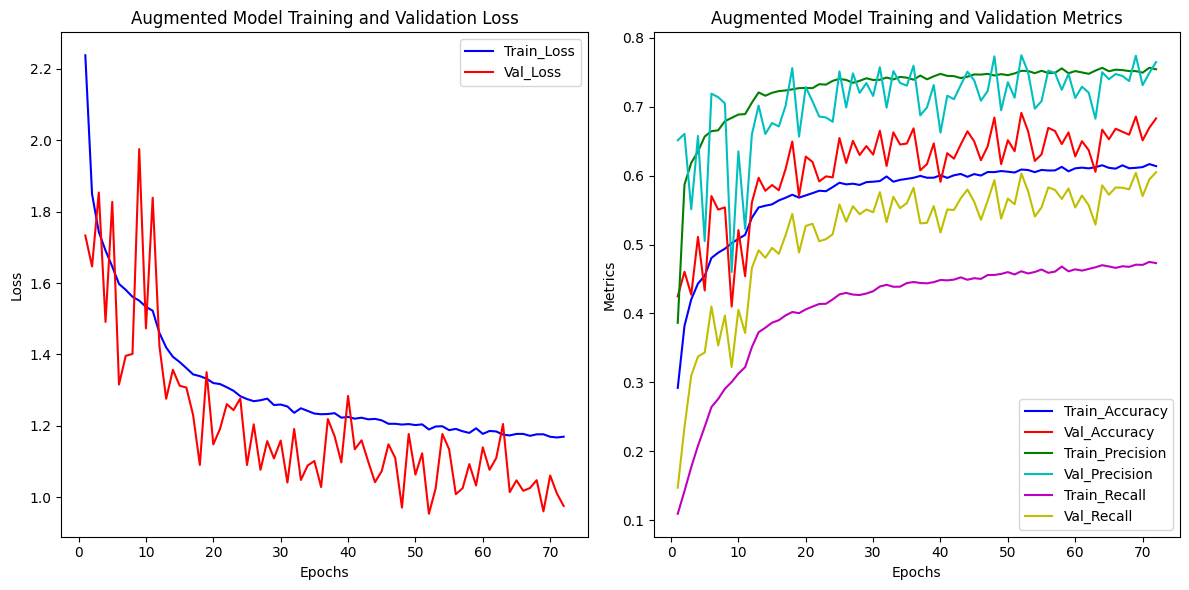

In [ ]:
# Accessing training history from the 'history' object
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']
training_precision = history2.history['precision']
validation_precision = history2.history['val_precision']
training_recall = history2.history['recall']
validation_recall = history2.history['val_recall']

# Number of epochs
epochs = range(1, len(training_loss) + 1)

# creating a plot
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(epochs, training_loss, 'b-', label='Train_Loss')
plt.plot(epochs, validation_loss, 'r-', label='Val_Loss')
plt.title('Augmented Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Metrics
plt.subplot(122)
plt.plot(epochs, training_accuracy, 'b-', label='Train_Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Val_Accuracy')
plt.plot(epochs, training_precision, 'g-', label='Train_Precision')
plt.plot(epochs, validation_precision, 'c-', label='Val_Precision')
plt.plot(epochs, training_recall, 'm-', label='Train_Recall')
plt.plot(epochs, validation_recall, 'y-', label='Val_Recall')
plt.title('Augmented Model Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()


plt.tight_layout()
plt.show()

## Model output
With the validation set performing slightly better than the training set across all metrics indicates underfitting. Augmentation techniques could have made the training set a little too complex.

Decided to optimize the baseline model instead since it was fairly balanced across the evaluation metrics.

#Using Pre-trained Model: VGG16

In [ ]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model
base_model.trainable = False

# Create the model
model3 = tf.keras.models.Sequential()

# Add the pre-trained base model
model3.add(base_model)

# Add new custom layers
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model3.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14782154 (56.39 MB)
Trainable params: 672

In [ ]:
# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model3.fit(train_generator,
                    epochs=100,  # Reduced epochs since we are using transfer learning
                    validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr])

model3.save("model3.h5")


Epoch 1/100
938/938 [==============================] - 19s 18ms/step - loss: 1.4107 - accuracy: 0.5125 - precision: 0.6833 - recall: 0.3275 - val_loss: 1.3028 - val_accuracy: 0.5483 - val_precision: 0.6875 - val_recall: 0.3891 - lr: 0.0010
Epoch 2/100
938/938 [==============================] - 16s 17ms/step - loss: 1.2338 - accuracy: 0.5718 - precision: 0.7160 - recall: 0.4086 - val_loss: 1.2490 - val_accuracy: 0.5646 - val_precision: 0.6903 - val_recall: 0.4236 - lr: 0.0010
Epoch 3/100
938/938 [==============================] - 16s 17ms/step - loss: 1.1890 - accuracy: 0.5867 - precision: 0.7311 - recall: 0.4328 - val_loss: 1.2416 - val_accuracy: 0.5659 - val_precision: 0.6970 - val_recall: 0.4310 - lr: 0.0010
Epoch 4/100
938/938 [==============================] - 15s 17ms/step - loss: 1.1636 - accuracy: 0.5976 - precision: 0.7333 - recall: 0.4433 - val_loss: 1.2260 - val_accuracy: 0.5768 - val_precision: 0.6982 - val_recall: 0.4380 - lr: 0.0010
Epoch 5/100
938/938 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
precision = model3.evaluate(train_generator, verbose=1)[2]
precision_v = model3.evaluate(val_generator, verbose=1)[2]
print("Precision: ", precision)
print("Validation Precision: ", precision_v)

625/625 [==============================] - 6s 9ms/step - loss: 1.1515 - accuracy: 0.6048 - precision: 0.7056 - recall: 0.5055
Precision:  0.8207384347915649
Validation Precision:  0.7056400775909424


In [ ]:
# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model3.fit(train_generator2,
                    epochs=100,  # Reduced epochs since we are using transfer learning
                    validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr])

model3.save("model4.h5")

Epoch 1/100
938/938 [==============================] - 32s 35ms/step - loss: 1.3705 - accuracy: 0.5270 - precision: 0.6695 - recall: 0.3728 - val_loss: 1.1814 - val_accuracy: 0.5883 - val_precision: 0.7071 - val_recall: 0.4645 - lr: 1.0000e-04
Epoch 2/100
938/938 [==============================] - 32s 34ms/step - loss: 1.3667 - accuracy: 0.5220 - precision: 0.6720 - recall: 0.3605 - val_loss: 1.1865 - val_accuracy: 0.5863 - val_precision: 0.7068 - val_recall: 0.4570 - lr: 1.0000e-04
Epoch 3/100
938/938 [==============================] - 32s 34ms/step - loss: 1.3527 - accuracy: 0.5268 - precision: 0.6787 - recall: 0.3606 - val_loss: 1.1832 - val_accuracy: 0.5874 - val_precision: 0.7065 - val_recall: 0.4570 - lr: 1.0000e-04
Epoch 4/100
938/938 [==============================] - 32s 34ms/step - loss: 1.3520 - accuracy: 0.5274 - precision: 0.6849 - recall: 0.3607 - val_loss: 1.1888 - val_accuracy: 0.5834 - val_precision: 0.7108 - val_recall: 0.4505 - lr: 1.0000e-04
Epoch 5/100
938/938 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model3.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fine-tune the model
history_fine = model3.fit(train_generator,
                         epochs=20,  # Few epochs for fine-tuning
                         validation_data=val_generator,
                         callbacks=[early_stopping, reduce_lr])
model3.save("model5.h5")

Epoch 1/20
938/938 [==============================] - 44s 39ms/step - loss: 0.8648 - accuracy: 0.6969 - precision: 0.8007 - recall: 0.5915 - val_loss: 0.7977 - val_accuracy: 0.7214 - val_precision: 0.8011 - val_recall: 0.6435 - lr: 1.0000e-05
Epoch 2/20
938/938 [==============================] - 37s 39ms/step - loss: 0.6309 - accuracy: 0.7833 - precision: 0.8557 - recall: 0.7117 - val_loss: 0.6909 - val_accuracy: 0.7617 - val_precision: 0.8301 - val_recall: 0.6991 - lr: 1.0000e-05
Epoch 3/20
938/938 [==============================] - 36s 38ms/step - loss: 0.4959 - accuracy: 0.8286 - precision: 0.8867 - recall: 0.7729 - val_loss: 0.6665 - val_accuracy: 0.7701 - val_precision: 0.8219 - val_recall: 0.7221 - lr: 1.0000e-05
Epoch 4/20
938/938 [==============================] - 41s 43ms/step - loss: 0.3956 - accuracy: 0.8690 - precision: 0.9114 - recall: 0.8220 - val_loss: 0.6215 - val_accuracy: 0.7882 - val_precision: 0.8394 - val_recall: 0.7457 - lr: 1.0000e-05
Epoch 5/20
938/938 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
precision = model3.evaluate(train_generator, verbose=1)[2]
precision_v = model3.evaluate(val_generator, verbose=1)[2]
print("Precision: ", precision)
print("Validation Precision: ", precision_v)

625/625 [==============================] - 7s 11ms/step - loss: 0.6071 - accuracy: 0.8013 - precision: 0.8376 - recall: 0.7742
Precision:  0.9855234622955322
Validation Precision:  0.8376068472862244


## Model(s) Output:

The first model (3):Trained the traingen(without augmented data) on the pretrained model. Was with some layers frozen. It generalized fairly well especially on precision, however not satisfactorily. the loss was still high on the validation set despite it gradually reducing during epoch iterations.


The second model(4):Trained the traingen2(with augmented data) on the pretrained model. Was with some layers frozen. clear underfitiing still visible whe using this train_generator2. the metrics were lower.


The third model (5) was trained on the inital traingen(without augmented data) and generalized much better with a 81% precision and 79% accuracy on the validation set. For this, had to unfreeze some layers in the base model for fine-tuning. The loss is also much lower than the other models trained.

Decided to try another pre-trained model ResNet50 see if the model can be optimized further.

#Using Pre-trained Model: ResNet50


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Load the pre-trained ResNet50 model without the top layers
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom top layers
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

# Create the final model
model4 = Model(inputs=base_model2.input, outputs=x)

# Freeze the base model layers (optional, you can fine-tune if needed)
for layer in base_model2.layers:
    layer.trainable = False

# Compile the model
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model4.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model4.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stopping])
model4.save("model6.h5")

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
precision = model4.evaluate(train_generator, verbose=1)[2]
precision_v = model4.evaluate(val_generator, verbose=1)[2]
print("Precision: ", precision)
print("Validation Precision: ", precision_v)

625/625 [==============================] - 14s 22ms/step - loss: 1.6083 - accuracy: 0.4208 - precision: 0.6679 - recall: 0.1628
Precision:  0.6874157786369324
Validation Precision:  0.6678974628448486


In [ ]:
# Unfreeze some layers in the base model for fine-tuning
base_model2.trainable = True

# Recompile the model with a lower learning rate
model4.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fine-tune the model
history_fine2 = model4.fit(train_generator,
                         epochs=20,  # Few epochs for fine-tuning
                         validation_data=val_generator,
                         callbacks=[early_stopping, reduce_lr])
model4.save("model7.h5")

Epoch 1/20
938/938 [==============================] - 150s 102ms/step - loss: 8.2308 - accuracy: 0.2061 - precision: 0.2151 - recall: 0.1899 - val_loss: 10.5962 - val_accuracy: 0.1973 - val_precision: 0.2054 - val_recall: 0.1718 - lr: 1.0000e-05
Epoch 2/20
938/938 [==============================] - 84s 89ms/step - loss: 3.7228 - accuracy: 0.3091 - precision: 0.3447 - recall: 0.2546 - val_loss: 3.7531 - val_accuracy: 0.3223 - val_precision: 0.3801 - val_recall: 0.2494 - lr: 1.0000e-05
Epoch 3/20
938/938 [==============================] - 84s 90ms/step - loss: 2.2005 - accuracy: 0.3634 - precision: 0.4738 - recall: 0.2341 - val_loss: 2.6764 - val_accuracy: 0.3744 - val_precision: 0.4848 - val_recall: 0.2325 - lr: 1.0000e-05
Epoch 4/20
938/938 [==============================] - 83s 88ms/step - loss: 1.7450 - accuracy: 0.4253 - precision: 0.5882 - recall: 0.2451 - val_loss: 2.0278 - val_accuracy: 0.4373 - val_precision: 0.5704 - val_recall: 0.2666 - lr: 1.0000e-05
Epoch 5/20
938/938 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model(s) output:
The first model (with frozen layers) did fairly well but improved significantly on the second training with unfreezing some layers in the base model.

The VGG16 model however still has better evaluation meric scores compared to ResNet50

#Model Evaluation

Evaluating the models on the test data

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#Model1: Baseline model on train_generator
saved_model_path = '/content/model1.h5'
model1 = load_model(saved_model_path)

evaluation_results = model1.evaluate(x_test, y_test)

print("Evaluation results:")
for name, value in zip(model1.metrics_names, evaluation_results):
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.0022 - accuracy: 0.7436 - precision: 0.8340 - recall: 0.6536
Evaluation results:
loss: 1.0022
accuracy: 0.7436
precision: 0.8340
recall: 0.6536


In [ ]:
#Model2: With Augmented data i.e train_generator2
saved_model_path = '/content/model2.h5'
model2 = load_model(saved_model_path)

evaluation_results = model2.evaluate(x_test, y_test)

print("Evaluation results:")
for name, value in zip(model2.metrics_names, evaluation_results):
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.9600 - accuracy: 0.6831 - precision: 0.7690 - recall: 0.5986
Evaluation results:
loss: 0.9600
accuracy: 0.6831
precision: 0.7690
recall: 0.5986


In [ ]:
#Model3:VGG16 fit on train_generator
saved_model_path = '/content/model3.h5'
model3 = load_model(saved_model_path)

evaluation_results = model3.evaluate(x_test, y_test)

print("Evaluation results:")
for name, value in zip(model3.metrics_names, evaluation_results):
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 3s 9ms/step - loss: 1.1743 - accuracy: 0.5972 - precision: 0.7030 - recall: 0.5017
Evaluation results:
loss: 1.1743
accuracy: 0.5972
precision: 0.7030
recall: 0.5017


In [ ]:
#Model4:VGG16 fit on train_generator2
saved_model_path = '/content/model4.h5'
model4 = load_model(saved_model_path)

evaluation_results = model4.evaluate(x_test, y_test)

print("Evaluation results:")
for name, value in zip(model4.metrics_names, evaluation_results):
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 4s 9ms/step - loss: 1.1947 - accuracy: 0.5886 - precision: 0.7144 - recall: 0.4415
Evaluation results:
loss: 1.1947
accuracy: 0.5886
precision: 0.7144
recall: 0.4415


In [ ]:
# Model5:unfreeze layers in the VGG16 base model: fit on train_generator
saved_model_path = '/content/model5.h5'
model5 = load_model(saved_model_path)

evaluation_results = model5.evaluate(x_test, y_test)

print("Evaluation results:")
for name, value in zip(model5.metrics_names, evaluation_results):
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 3s 9ms/step - loss: 0.6219 - accuracy: 0.7991 - precision: 0.8358 - recall: 0.7719
Evaluation results:
loss: 0.6219
accuracy: 0.7991
precision: 0.8358
recall: 0.7719


In [ ]:
# Model6:ResNet50 fit on train_generator
saved_model_path = '/content/model6.h5'
model6 = load_model(saved_model_path)

evaluation_results = model6.evaluate(x_test, y_test)

print("Evaluation results:")
for name, value in zip(model6.metrics_names, evaluation_results):
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 6s 14ms/step - loss: 1.6133 - accuracy: 0.4190 - precision: 0.6560 - recall: 0.1665
Evaluation results:
loss: 1.6133
accuracy: 0.4190
precision: 0.6560
recall: 0.1665


In [ ]:
# Model 7:unfreeze layers in the ResNet50 base model: fit on train_generator
saved_model_path = '/content/model7.h5'
model7 = load_model(saved_model_path)

evaluation_results = model7.evaluate(x_test, y_test)

print("Evaluation results:")
for name, value in zip(model7.metrics_names, evaluation_results):
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 5s 12ms/step - loss: 1.0888 - accuracy: 0.7092 - precision: 0.7467 - recall: 0.6752
Evaluation results:
loss: 1.0888
accuracy: 0.7092
precision: 0.7467
recall: 0.6752


In [ ]:
#All Together
# List of model file paths
model_files = ['/content/model1.h5', '/content/model2.h5', '/content/model3.h5', '/content/model4.h5', '/content/model5.h5', '/content/model6.h5', '/content/model7.h5']  # Update with your file paths

# List to store evaluation results
evaluation_results = []

# Load and evaluate each model
for model_file in model_files:
    model = load_model(model_file)
    evaluation_result = model.evaluate(x_test, y_test)
    evaluation_results.append(evaluation_result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(evaluation_results, columns=model.metrics_names)

# Add model names as index
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']  # Update with your model names
results_df.index = model_names

print("Evaluation results:")
print(results_df)


313/313 [==============================] - 5s 12ms/step - loss: 1.0888 - accuracy: 0.7092 - precision: 0.7467 - recall: 0.6752
Evaluation results:
             loss  accuracy  precision  recall
Model 1  1.002186    0.7436   0.833993  0.6536
Model 2  0.959992    0.6831   0.769013  0.5986
Model 3  1.174263    0.5972   0.702956  0.5017
Model 4  1.194718    0.5886   0.714401  0.4415
Model 5  0.621929    0.7991   0.835751  0.7719
Model 6  1.613324    0.4190   0.656028  0.1665
Model 7  1.088780    0.7092   0.746655  0.6752


## Evalution on test data output:
Model 5 performs better than all other models with the lowest loss and the highest accuracy,precision and recall.

#Model Testing

1/1 [==============================] - 0s 39ms/step


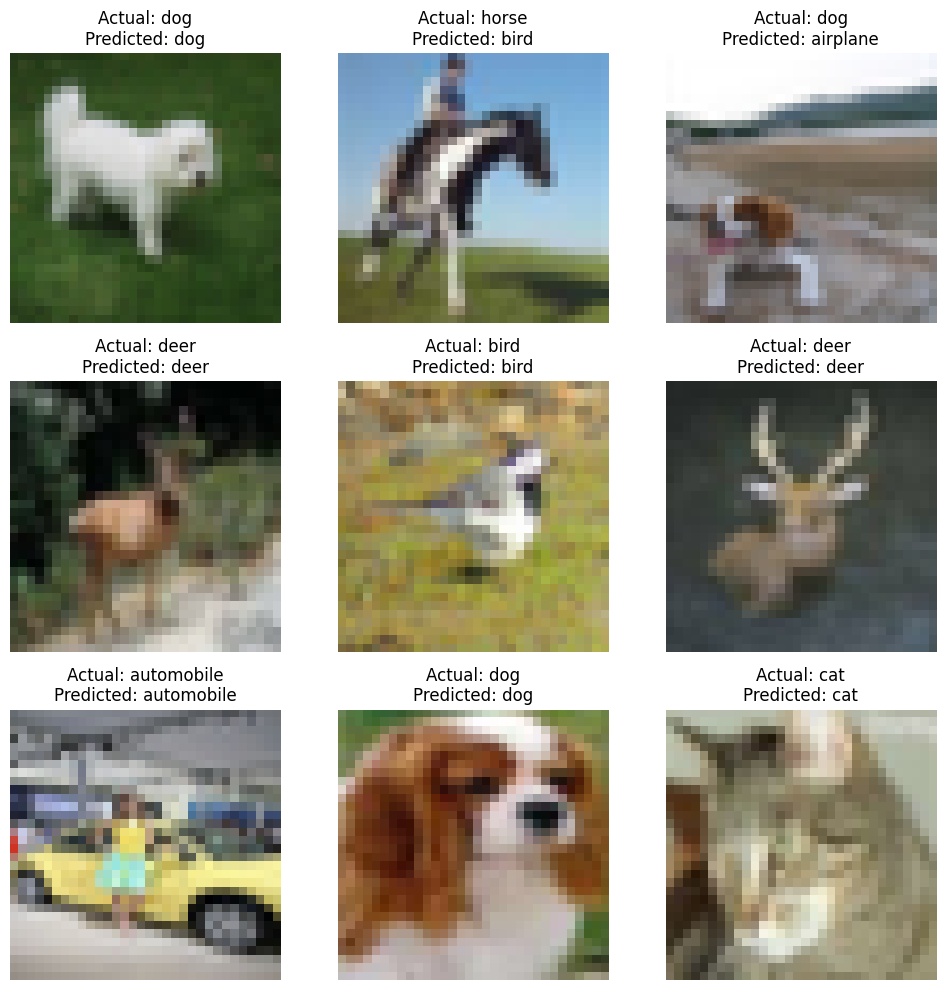

In [ ]:
# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 3

# Create an iterator from the test generator to access the test images and their labels
test_iterator = iter(test_generator)

# Create a figure with subplots for displaying the images in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define model file paths
model_files = ['/content/model5.h5']

# Load models and loop through the grid to display images with predictions
for i, model_file in enumerate(model_files):
    # Load the model from the file path
    model = tf.keras.models.load_model(model_file)

    for row in range(num_rows):
        for col in range(num_cols):
            # Get a batch of images and labels from the test generator
            images, labels = next(test_iterator)

            # Select the first image from the batch
            sample_image = images[0]

            # Resize the image to the target shape (assuming your model expects 32x32 images)
            sample_image = tf.image.resize(sample_image, (32, 32))

            # Make a prediction using the loaded model
            predictions = model.predict(sample_image[np.newaxis, ...])

            # Get the predicted class name
            predicted_class = class_names[np.argmax(predictions)]

            # Get the actual class name
            actual_class = class_names[np.argmax(labels[0])]

            # Display the image with the actual and predicted class names
            axes[row, col].imshow(sample_image.numpy())
            axes[row, col].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()
